In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/5153 Project/Dataset')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
data  = pd.read_csv('/content/drive/MyDrive/5153 Project/Dataset/train (1).csv')

In [4]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
_, _, y_train, y_test = train_test_split(data['text'], data['target'].values, test_size=0.25, random_state=42)

In [8]:
train_embedding = torch.load('/content/drive/MyDrive/5153 Project/BERT + Text CNN/train_embedding.pt').detach().numpy()

In [9]:
test_embedding = torch.load('/content/drive/MyDrive/5153 Project/BERT + Text CNN/test_embedding.pt').detach().numpy()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding,Flatten,LeakyReLU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, LayerNormalization , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [ ]:
def compile_model(model,lr=0.0001):
    opt = Adam(learning_rate=lr)
    model.compile(optimizer = opt,loss="binary_crossentropy", metrics = ['acc'])
def early_stopping_call_back(pati = 10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=pati,mode="max")
    return  early_stopping
def Checkpoint(name):
    mc=tf.keras.callbacks.ModelCheckpoint(f'{name}_best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1) 
    return mc

In [ ]:
def text_cnn_model(input_shape,dropout_rate=0.2,alpha_rate=0.1):
    embedding = Input(shape=input_shape)

    conv2 = Conv1D(filters =128,kernel_size=2,padding="valid",strides=1,name = '2_grams')(embedding)
    conv2 = LeakyReLU(alpha_rate)(conv2)
    conv3 = Conv1D(filters =128,kernel_size=3,padding="valid",strides=1,name = '3_grams')(embedding)
    conv3 = LeakyReLU(alpha_rate)(conv3)
    conv4 = Conv1D(filters =128,kernel_size=7,padding="valid",strides=1,name = '4_grams')(embedding)
    conv4 = LeakyReLU(alpha_rate)(conv4)
    conv5 = Conv1D(filters =128,kernel_size=5,padding="valid",strides=1,name = '5_grams')(embedding)
    conv5 = LeakyReLU(alpha_rate)(conv5)
    
    MaxPool1 = GlobalMaxPooling1D()(conv2)
    MaxPool2 = GlobalMaxPooling1D()(conv3)
    MaxPool3 = GlobalMaxPooling1D()(conv4)
    MaxPool4 = GlobalMaxPooling1D()(conv5)

    Flat = Flatten()(embedding[:,:,:])
    Concat = Concatenate()([MaxPool1,MaxPool2,MaxPool3,MaxPool4])
    x = LayerNormalization()(Concat)
    x = Dropout(dropout_rate)(Concat)

    x = Dense(1048)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64)(x)
    x = LeakyReLU(alpha=alpha_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    Output = Dense(1,activation='sigmoid')(x)
    return Model(embedding,Output)

In [ ]:
model = text_cnn_model(train_embedding[0].shape,0.5,0.5)
compile_model(model,lr=0.01)
cp = Checkpoint('Best_CNN')
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 32, 64)]     0           []                               
                                                                                                  
 2_grams (Conv1D)               (None, 31, 128)      16512       ['input_32[0][0]']               
                                                                                                  
 3_grams (Conv1D)               (None, 30, 128)      24704       ['input_32[0][0]']               
                                                                                                  
 4_grams (Conv1D)               (None, 26, 128)      57472       ['input_32[0][0]']               
                                                                                           

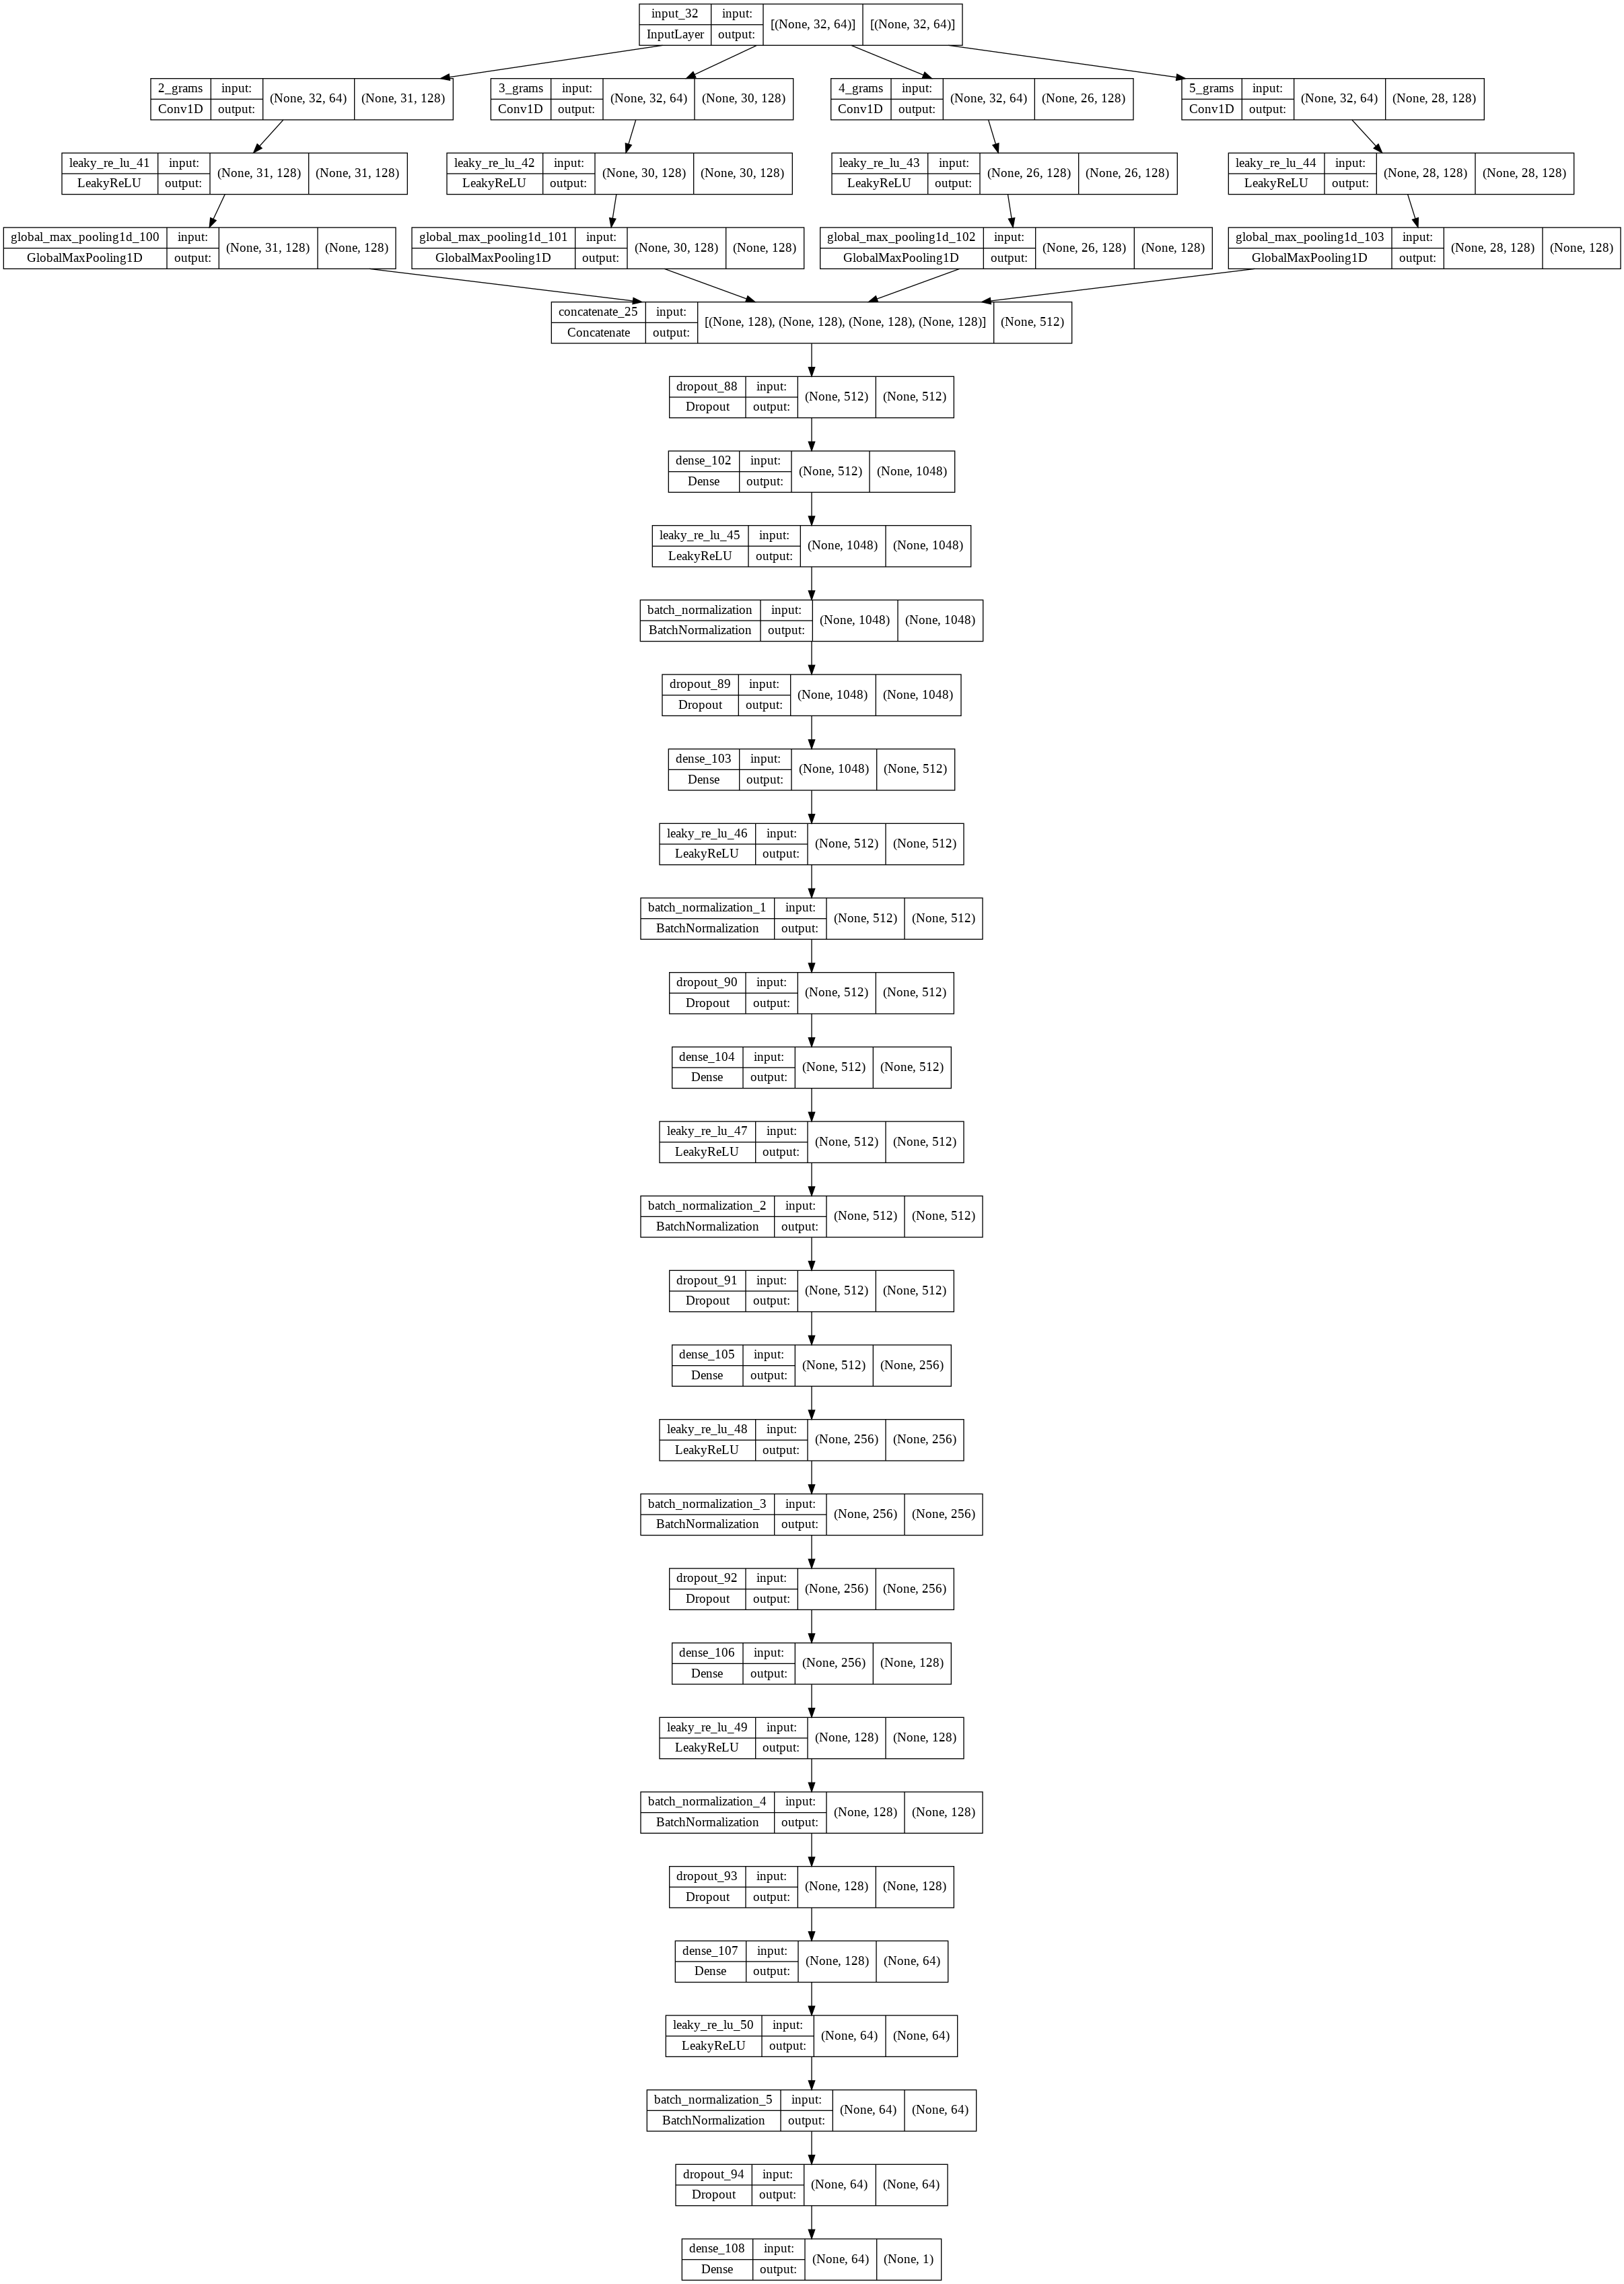

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_embedding,y_train,epochs=1000,batch_size = 1000,validation_split=0.2,callbacks = [cp])

Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 0.8837 - acc: 0.5443
Epoch 1: val_acc improved from -inf to 0.44396, saving model to Best_CNN_best_model.h5
5/5 [==============================] - 3s 172ms/step - loss: 0.8837 - acc: 0.5443 - val_loss: 15.1021 - val_acc: 0.4440
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 0.7325 - acc: 0.6061
Epoch 2: val_acc improved from 0.44396 to 0.45534, saving model to Best_CNN_best_model.h5
5/5 [==============================] - 0s 85ms/step - loss: 0.7325 - acc: 0.6061 - val_loss: 61.8175 - val_acc: 0.4553
Epoch 3/1000
5/5 [==============================] - ETA: 0s - loss: 0.6244 - acc: 0.6696
Epoch 3: val_acc did not improve from 0.45534
5/5 [==============================] - 0s 38ms/step - loss: 0.6244 - acc: 0.6696 - val_loss: 151.7392 - val_acc: 0.4536
Epoch 4/1000
3/5 [=================>............] - ETA: 0s - loss: 0.5721 - acc: 0.7130
Epoch 4: val_acc improved from 0.45534 to 0.48599, saving mode

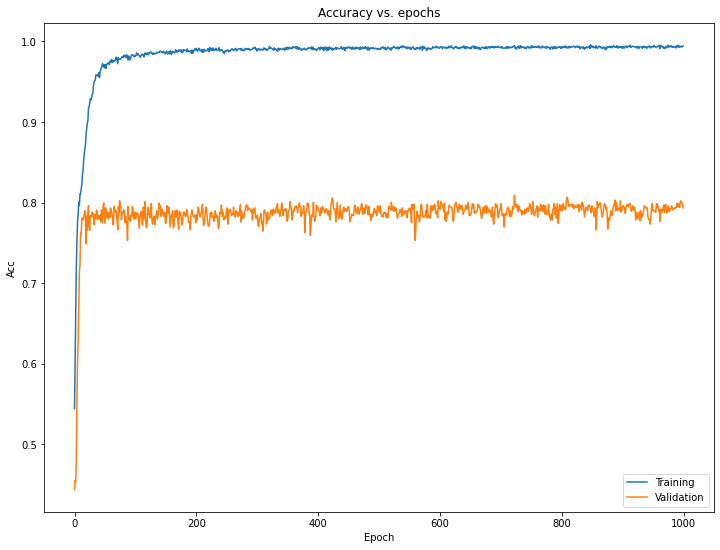

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [10]:
best_model = load_model('/content/drive/MyDrive/5153 Project/Dataset/Best_CNN_best_model.h5')

In [11]:
y_pred_proba = best_model.predict(test_embedding)

In [12]:
y_pred = np.where(y_pred_proba>0.5,1,0)

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
confusion_matrix(y_test,y_pred)

array([[937, 154],
       [235, 578]])

In [ ]:
accuracy_score(y_test,y_pred)

0.7956932773109243

In [ ]:
roc_auc_score(y_test,y_pred_proba)

0.8500343298575058

In [ ]:
f1_score(y_test,y_pred)

0.7482200647249192